# Análise Exploratória - QuantFund

Este notebook analisa a correlação entre:
- Preços de futuros de minério de ferro (SGX)
- Preços de VALE3 (B3)

**Hipótese**: Variações nos preços de minério de ferro podem prever movimentos de VALE3.

## 1. Setup e Imports

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Supabase client
from jobs.clients.supabase_client import get_supabase_client

print("Setup concluído!")

Setup concluído!


## 2. Carregando Dados do Supabase

In [2]:
# Inicializa cliente Supabase
client = get_supabase_client()

def fetch_all_records(table_name: str, order_by: str = 'timestamp') -> pd.DataFrame:
    """Busca TODOS os registros de uma tabela usando paginação."""
    all_data = []
    page_size = 1000
    offset = 0
    
    while True:
        response = (client.client.table(table_name)
                    .select('*')
                    .order(order_by)
                    .range(offset, offset + page_size - 1)
                    .execute())
        
        if not response.data:
            break
            
        all_data.extend(response.data)
        
        if len(response.data) < page_size:
            break
            
        offset += page_size
    
    return pd.DataFrame(all_data)

# Busca TODOS os dados com paginação
vale3_df = fetch_all_records('prices_vale3')
iron_df = fetch_all_records('prices_iron_ore')
aux_df = fetch_all_records('auxiliary_data')

print(f"VALE3: {len(vale3_df)} registros")
print(f"Minério de ferro: {len(iron_df)} registros")
print(f"Dados auxiliares: {len(aux_df)} registros")
print(f"\nFontes de dados:")
print(f"  - Yahoo Finance: histórico longo (backfill)")
print(f"  - LSEG: dados recentes/realtime")

2026-01-16 03:45:36.708 | INFO     | jobs.clients.supabase_client:__init__:33 - Conexão Supabase inicializada


VALE3: 1758 registros
Minério de ferro: 1300 registros
Dados auxiliares: 1305 registros

Fontes de dados:
  - Yahoo Finance: histórico longo (backfill)
  - LSEG: dados recentes/realtime


## 3. Preparação e Normalização dos Dados

**Problema**: Mercados operam em horários e dias diferentes:
- SGX (Singapura): T-Session 20:25-09:00 BRT, T+1 09:00-17:45 BRT
- B3 (Brasil): Pregão 10:00-17:55 BRT
- Feriados diferentes entre Brasil e Singapura

**Alinhamento Temporal (Dados Diários)**:
```
Timeline de um dia típico (BRT):
00:00 ─── 09:00 ────── 10:00 ────────────── 17:55 ─── 22:00
          │            │                    │         │
          Minério      VALE3                VALE3     Minério
          fecha        abre                 fecha     abre
          (D0)         (D0)                 (D0)      (D+1)
```
→ O settlement do minério de D0 está disponível ANTES de VALE3 abrir em D0.
→ Isso é correto para a hipótese de que minério "prevê" VALE3.

**Solução para gaps (feriados diferentes)**:
1. Forward fill: quando um ativo não opera, usa último valor conhecido
2. Filtrar apenas dias onde VALE3 tem cotação (B3 aberta = dia de decisão)

In [3]:
# Converte timestamps para datetime (formato ISO8601)
vale3_df['timestamp'] = pd.to_datetime(vale3_df['timestamp'], format='ISO8601')
iron_df['timestamp'] = pd.to_datetime(iron_df['timestamp'], format='ISO8601')
aux_df['timestamp'] = pd.to_datetime(aux_df['timestamp'], format='ISO8601')

# Extrai apenas a data (sem hora) para merge
vale3_df['date'] = vale3_df['timestamp'].dt.date
iron_df['date'] = iron_df['timestamp'].dt.date
aux_df['date'] = aux_df['timestamp'].dt.date

# SZZFc2 é rolling chain (contrato contínuo) - já representa front month automaticamente
# Não precisa filtrar por expiry_date pois contratos contínuos não têm essa propriedade
# Se houver múltiplos registros por dia, pega o último (mais recente)
iron_front = iron_df.groupby('date').last().reset_index()

print(f"\nVALE3 - Período: {vale3_df['date'].min()} a {vale3_df['date'].max()}")
print(f"Minério - Período: {iron_front['date'].min()} a {iron_front['date'].max()}")
print(f"Auxiliar - Período: {aux_df['date'].min()} a {aux_df['date'].max()}")


VALE3 - Período: 2021-01-18 a 2026-01-16
Minério - Período: 2021-01-04 a 2026-01-15
Auxiliar - Período: 2021-01-18 a 2026-01-16


In [4]:
# ============================================================
# NORMALIZAÇÃO COM FORWARD FILL
# ============================================================
# Estratégia:
# 1. Criar série temporal completa para cada ativo
# 2. Forward fill para preencher gaps (feriados)
# 3. Filtrar apenas dias onde B3 operou (decisão de trading)

# Prepara dados diários de VALE3
vale3_daily = vale3_df.groupby('date').last()[['close']].reset_index()
vale3_daily.columns = ['date', 'vale3_close']
vale3_daily['date'] = pd.to_datetime(vale3_daily['date'])
vale3_daily = vale3_daily.set_index('date').sort_index()

# Prepara dados diários de Minério
iron_daily = iron_front[['date', 'price']].copy()
iron_daily.columns = ['date', 'iron_ore_price']
iron_daily['date'] = pd.to_datetime(iron_daily['date'])
iron_daily = iron_daily.set_index('date').sort_index()

# Prepara dados auxiliares
aux_daily = aux_df.groupby('date').last()[['usd_brl', 'vix']].reset_index()
aux_daily['date'] = pd.to_datetime(aux_daily['date'])
aux_daily = aux_daily.set_index('date').sort_index()

# Cria índice de datas completo (range total)
all_dates = pd.date_range(
    start=min(vale3_daily.index.min(), iron_daily.index.min()),
    end=max(vale3_daily.index.max(), iron_daily.index.max()),
    freq='D'
)

# Reindex cada série com forward fill
vale3_filled = vale3_daily.reindex(all_dates).ffill()
iron_filled = iron_daily.reindex(all_dates).ffill()
aux_filled = aux_daily.reindex(all_dates).ffill()

# Combina tudo
df = pd.concat([vale3_filled, iron_filled, aux_filled], axis=1)
df.index.name = 'date'

# Estatísticas de forward fill
vale3_original = vale3_daily.dropna().shape[0]
iron_original = iron_daily.dropna().shape[0]
vale3_after_fill = vale3_filled.dropna().shape[0]
iron_after_fill = iron_filled.dropna().shape[0]

print("Forward Fill aplicado:")
print(f"  VALE3:   {vale3_original} → {vale3_after_fill} dias (+{vale3_after_fill - vale3_original} preenchidos)")
print(f"  Minério: {iron_original} → {iron_after_fill} dias (+{iron_after_fill - iron_original} preenchidos)")

# Filtra apenas dias onde B3 operou (VALE3 tem dados originais)
# Isso é importante: só consideramos dias de "decisão de trading"
b3_trading_days = vale3_daily.dropna().index
df = df.loc[df.index.isin(b3_trading_days)]

# Remove dias sem dados de minério (início da série)
df = df.dropna(subset=['vale3_close', 'iron_ore_price'])

print(f"\nDataFrame final: {len(df)} registros (dias de pregão B3 com dados)")
print(f"Período: {df.index.min().date()} a {df.index.max().date()}")
df.head()

Forward Fill aplicado:
  VALE3:   1247 → 1825 dias (+578 preenchidos)
  Minério: 1300 → 1839 dias (+539 preenchidos)

DataFrame final: 1247 registros (dias de pregão B3 com dados)
Período: 2021-01-18 a 2026-01-16


,vale3_close,iron_ore_price,usd_brl,vix
date,,,,
2021-01-18,54.51,170.26,5.2913,NaN
2021-01-19,54.36,167.03,5.2948,23.24
2021-01-20,53.36,165.97,5.3567,21.58
2021-01-21,53.96,167.60,5.2905,21.32
2021-01-22,53.85,166.14,5.3495,21.91


## 4. Estatísticas Descritivas

In [5]:
df[['vale3_close', 'iron_ore_price', 'usd_brl', 'vix']].describe()

,vale3_close,iron_ore_price,usd_brl,vix
count,1247.000000,1247.000000,1247.000000,1246.000000
mean,56.025822,120.391588,5.304109,19.207945
std,6.831690,27.541259,0.315220,5.252186
min,42.380000,78.100000,4.593800,11.860000
25%,50.955000,102.195000,5.054450,15.440000
50%,53.810000,110.030000,5.291500,17.950000
75%,60.435000,129.230000,5.528350,21.762500
max,78.920000,227.340000,6.300000,52.330000


In [6]:
# Calcula retornos diários
df['vale3_return'] = df['vale3_close'].pct_change() * 100
df['iron_return'] = df['iron_ore_price'].pct_change() * 100
df['usd_brl_return'] = df['usd_brl'].pct_change() * 100 if 'usd_brl' in df.columns else 0

print("Retornos diários (%)")
df[['vale3_return', 'iron_return']].describe()

Retornos diários (%)


,vale3_return,iron_return
count,1246.000000,1246.000000
mean,0.046966,-0.006837
std,1.867135,2.462941
min,-7.585926,-12.443014
25%,-1.035514,-1.270050
50%,-0.021758,0.044635
75%,0.989865,1.268927
max,10.404624,14.976516


## 5. Visualização dos Preços

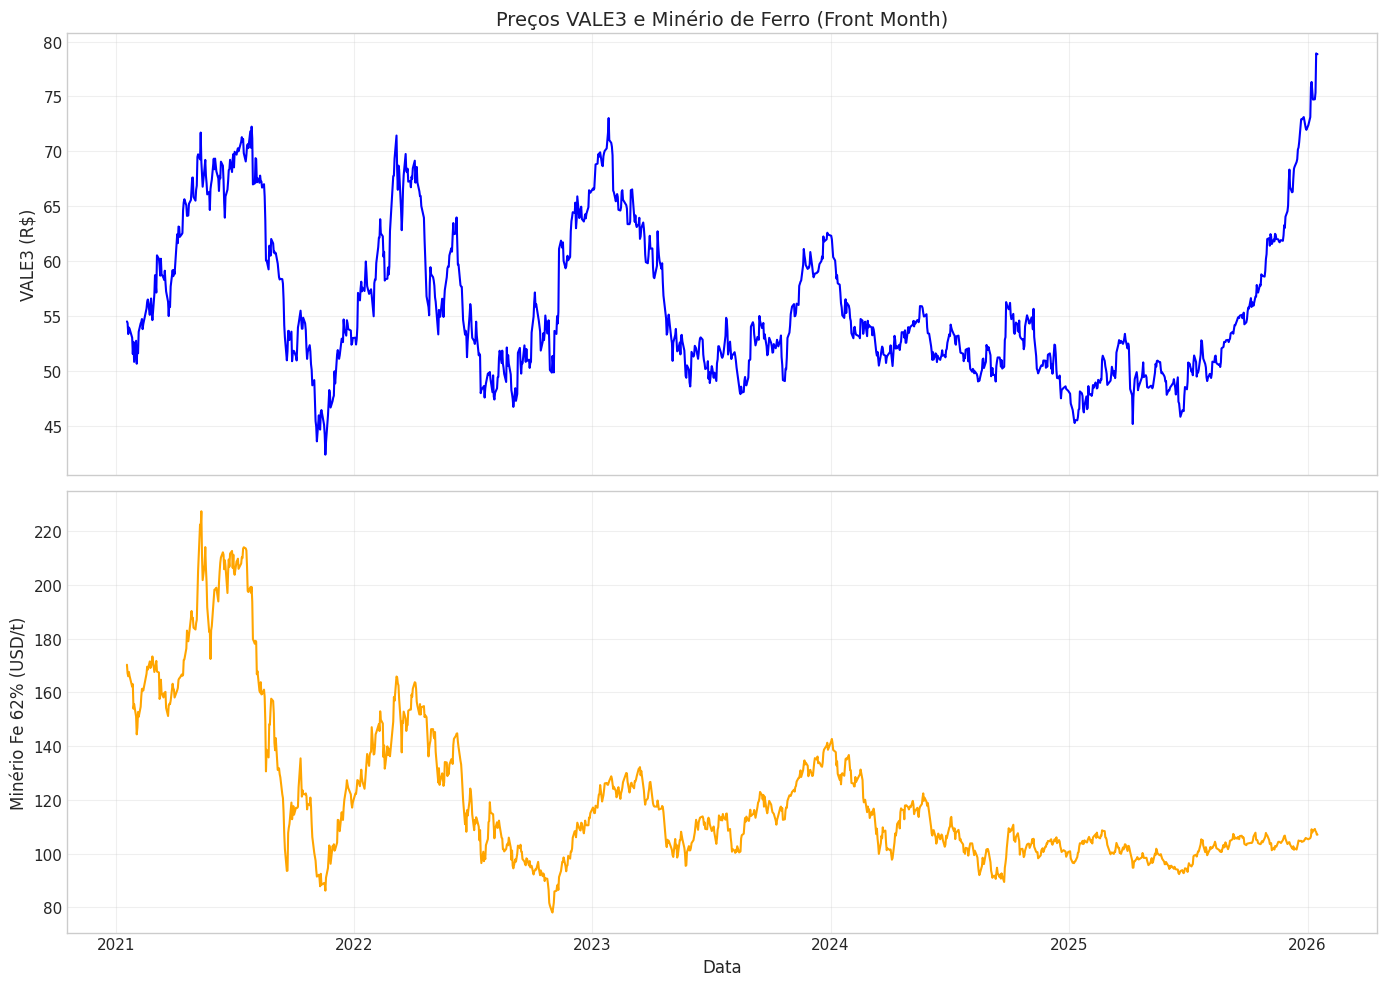

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# VALE3
axes[0].plot(df.index, df['vale3_close'], color='blue', linewidth=1.5)
axes[0].set_ylabel('VALE3 (R$)', fontsize=12)
axes[0].set_title('Preços VALE3 e Minério de Ferro (Front Month)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Minério
axes[1].plot(df.index, df['iron_ore_price'], color='orange', linewidth=1.5)
axes[1].set_ylabel('Minério Fe 62% (USD/t)', fontsize=12)
axes[1].set_xlabel('Data', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

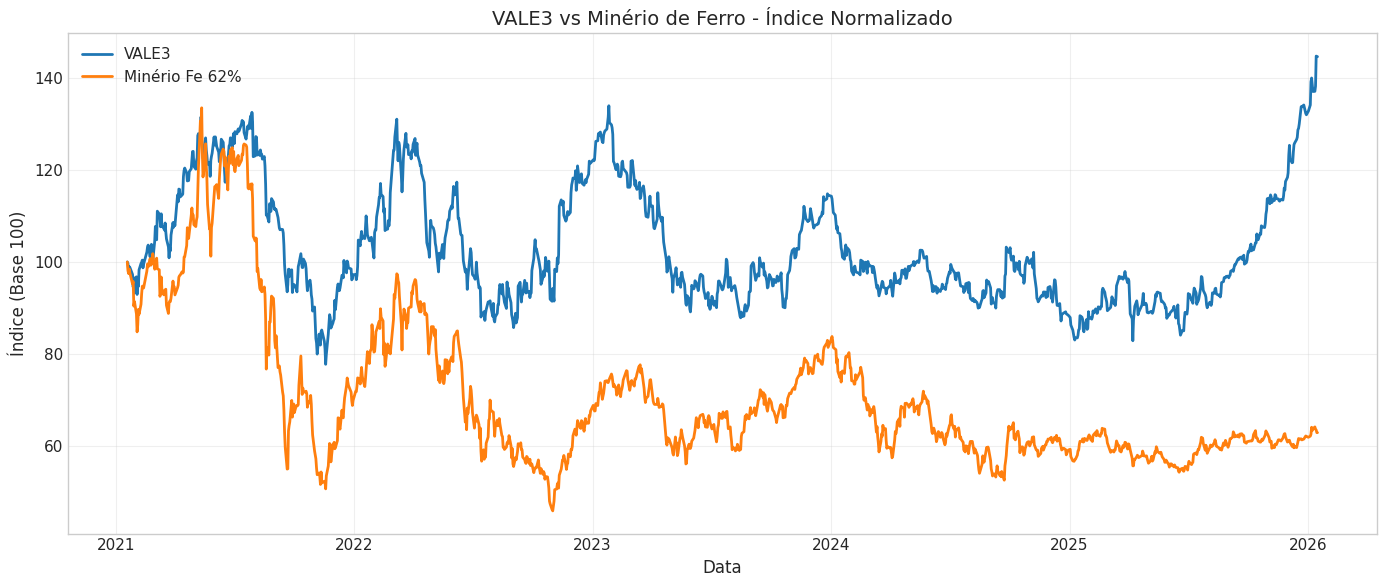

In [8]:
# Preços normalizados para comparação
fig, ax = plt.subplots(figsize=(14, 6))

# Normaliza para base 100
vale3_norm = (df['vale3_close'] / df['vale3_close'].iloc[0]) * 100
iron_norm = (df['iron_ore_price'] / df['iron_ore_price'].iloc[0]) * 100

ax.plot(df.index, vale3_norm, label='VALE3', linewidth=2)
ax.plot(df.index, iron_norm, label='Minério Fe 62%', linewidth=2)

ax.set_ylabel('Índice (Base 100)', fontsize=12)
ax.set_xlabel('Data', fontsize=12)
ax.set_title('VALE3 vs Minério de Ferro - Índice Normalizado', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Análise de Correlação

In [9]:
# Correlação entre retornos
correlation_returns = df['vale3_return'].corr(df['iron_return'])
print(f"Correlação entre retornos diários: {correlation_returns:.4f}")

# Correlação entre preços
correlation_prices = df['vale3_close'].corr(df['iron_ore_price'])
print(f"Correlação entre preços: {correlation_prices:.4f}")

Correlação entre retornos diários: 0.4355
Correlação entre preços: 0.6434


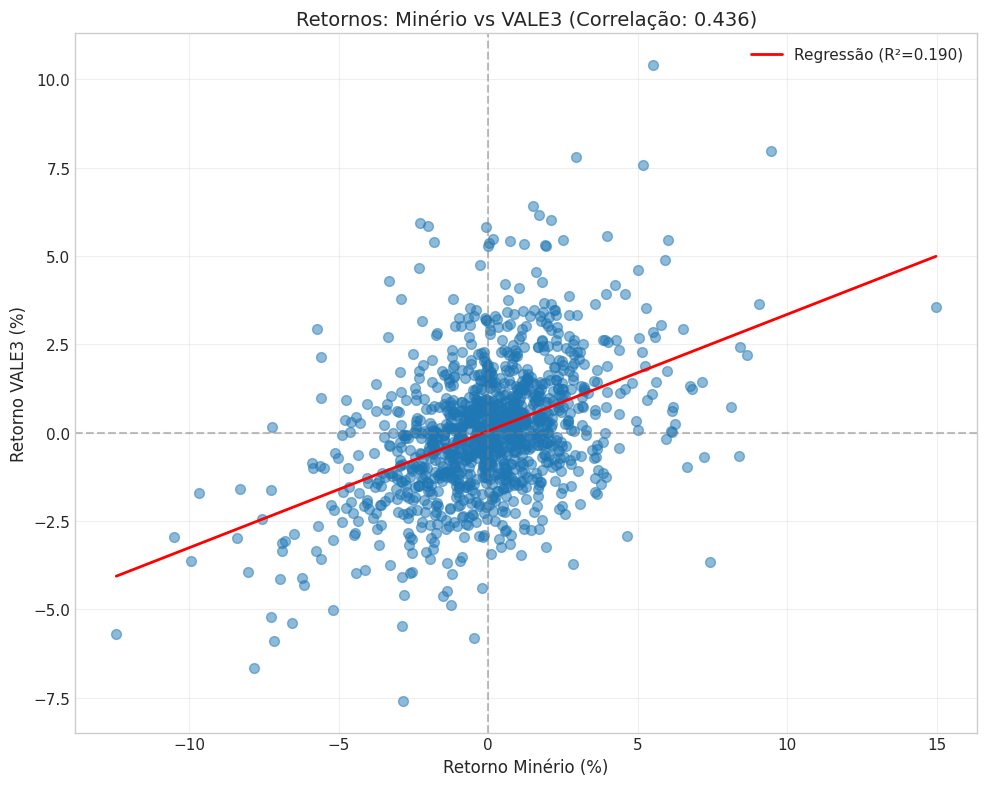


Regressão: VALE3_return = 0.3302 * Iron_return + 0.0492
P-value: 0.000000


In [10]:
# Scatter plot de retornos
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(df['iron_return'], df['vale3_return'], alpha=0.5, s=50)

# Linha de regressão
from scipy import stats
mask = ~(df['iron_return'].isna() | df['vale3_return'].isna())
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df.loc[mask, 'iron_return'], 
    df.loc[mask, 'vale3_return']
)

x_line = np.linspace(df['iron_return'].min(), df['iron_return'].max(), 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='red', linewidth=2, label=f'Regressão (R²={r_value**2:.3f})')

ax.set_xlabel('Retorno Minério (%)', fontsize=12)
ax.set_ylabel('Retorno VALE3 (%)', fontsize=12)
ax.set_title(f'Retornos: Minério vs VALE3 (Correlação: {correlation_returns:.3f})', fontsize=14)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRegressão: VALE3_return = {slope:.4f} * Iron_return + {intercept:.4f}")
print(f"P-value: {p_value:.6f}")

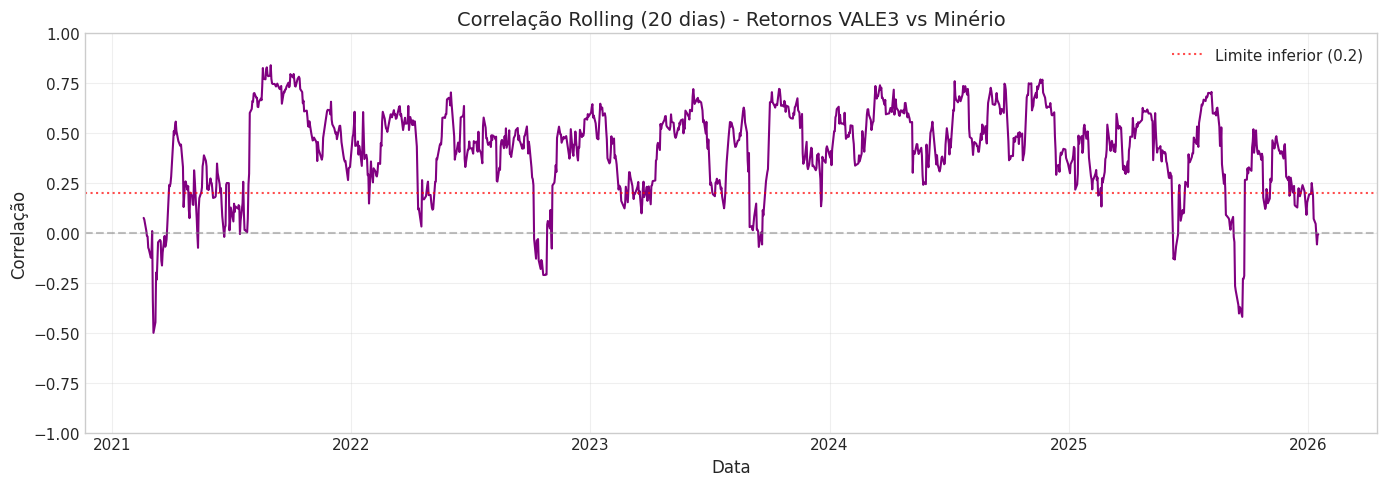


Correlação média: 0.4110
Correlação mínima: -0.5004
Correlação máxima: 0.8402


In [11]:
# Correlação rolling (janela de 20 dias)
rolling_corr = df['vale3_return'].rolling(window=20).corr(df['iron_return'])

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df.index, rolling_corr, color='purple', linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.2, color='red', linestyle=':', alpha=0.7, label='Limite inferior (0.2)')

ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Correlação', fontsize=12)
ax.set_title('Correlação Rolling (20 dias) - Retornos VALE3 vs Minério', fontsize=14)
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelação média: {rolling_corr.mean():.4f}")
print(f"Correlação mínima: {rolling_corr.min():.4f}")
print(f"Correlação máxima: {rolling_corr.max():.4f}")

## 7. Análise de Defasagem (Lead-Lag)

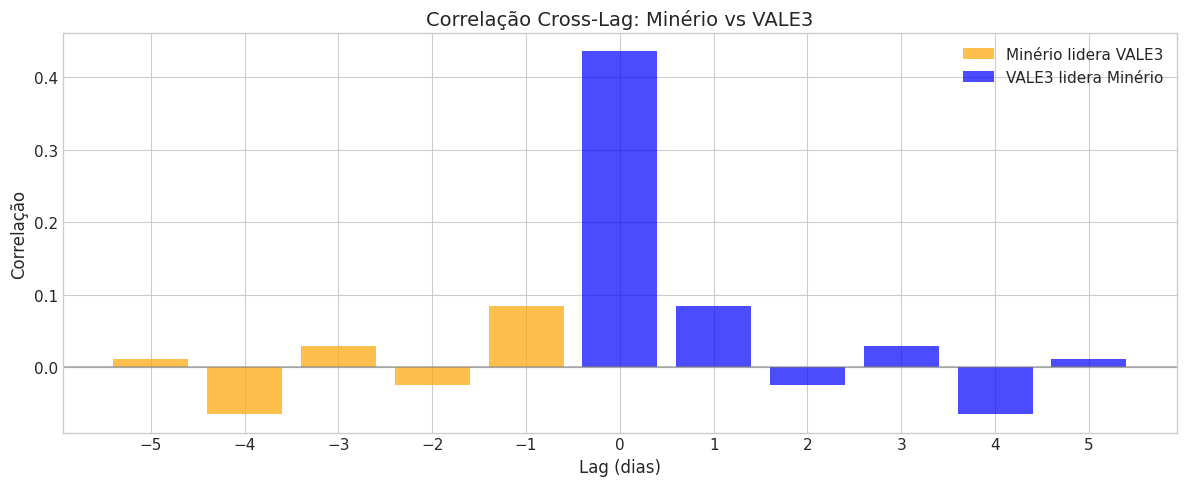


Correlações por lag:
  Lag -5: 0.0110 (Minério lidera)
  Lag -4: -0.0651 (Minério lidera)
  Lag -3: 0.0294 (Minério lidera)
  Lag -2: -0.0240 (Minério lidera)
  Lag -1: 0.0851 (Minério lidera)
  Lag +0: 0.4355 (VALE3 lidera)
  Lag +1: 0.0851 (VALE3 lidera)
  Lag +2: -0.0240 (VALE3 lidera)
  Lag +3: 0.0294 (VALE3 lidera)
  Lag +4: -0.0651 (VALE3 lidera)
  Lag +5: 0.0110 (VALE3 lidera)


In [12]:
# Correlação com diferentes lags
# Hipótese: Minério D-1 prevê VALE3 D0
lags = range(-5, 6)  # -5 a +5 dias
lag_correlations = []

for lag in lags:
    if lag < 0:
        # Minério lidera (minério D-lag correlaciona com VALE3 D0)
        corr = df['vale3_return'].corr(df['iron_return'].shift(-lag))
    else:
        # VALE3 lidera (vale3 D-lag correlaciona com minério D0)
        corr = df['vale3_return'].shift(-lag).corr(df['iron_return'])
    lag_correlations.append(corr)

fig, ax = plt.subplots(figsize=(12, 5))

bars = ax.bar(lags, lag_correlations, color=['orange' if l < 0 else 'blue' for l in lags], alpha=0.7)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

ax.set_xlabel('Lag (dias)', fontsize=12)
ax.set_ylabel('Correlação', fontsize=12)
ax.set_title('Correlação Cross-Lag: Minério vs VALE3', fontsize=14)
ax.set_xticks(list(lags))

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='orange', alpha=0.7, label='Minério lidera VALE3'),
    Patch(facecolor='blue', alpha=0.7, label='VALE3 lidera Minério')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\nCorrelações por lag:")
for lag, corr in zip(lags, lag_correlations):
    leader = 'Minério' if lag < 0 else 'VALE3'
    print(f"  Lag {lag:+d}: {corr:.4f} ({leader} lidera)")

## 8. Teste de Causalidade de Granger

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepara dados (remove NaN)
granger_df = df[['vale3_return', 'iron_return']].dropna()

print("Teste de Granger: Minério -> VALE3")
print("=" * 50)
print("H0: Minério NÃO causa VALE3")
print("Se p-value < 0.05, rejeitamos H0 (minério causa VALE3)")
print()

# Testa se minério Granger-causa VALE3
granger_result = grangercausalitytests(
    granger_df[['vale3_return', 'iron_return']], 
    maxlag=5, 
    verbose=True
)

Teste de Granger: Minério -> VALE3
H0: Minério NÃO causa VALE3
Se p-value < 0.05, rejeitamos H0 (minério causa VALE3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7282  , p=0.0055  , df_denom=1242, df_num=1
ssr based chi2 test:   chi2=7.7468  , p=0.0054  , df=1
likelihood ratio test: chi2=7.7228  , p=0.0055  , df=1
parameter F test:         F=7.7282  , p=0.0055  , df_denom=1242, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2751  , p=0.0141  , df_denom=1239, df_num=2
ssr based chi2 test:   chi2=8.5846  , p=0.0137  , df=2
likelihood ratio test: chi2=8.5551  , p=0.0139  , df=2
parameter F test:         F=4.2751  , p=0.0141  , df_denom=1239, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3343  , p=0.0189  , df_denom=1236, df_num=3
ssr based chi2 test:   chi2=10.0596 , p=0.0181  , df=3
likelihood ratio test: chi2=10.0191 , p=0.0184  , df=3
parameter F test:         F=3.3343  , p=0.0

/home/bigode/quantfund/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [14]:
print("\nTeste de Granger: VALE3 -> Minério")
print("=" * 50)
print("H0: VALE3 NÃO causa Minério")
print("Se p-value < 0.05, rejeitamos H0")
print()

# Testa se VALE3 Granger-causa minério (reverso)
granger_result_reverse = grangercausalitytests(
    granger_df[['iron_return', 'vale3_return']], 
    maxlag=5, 
    verbose=True
)


Teste de Granger: VALE3 -> Minério
H0: VALE3 NÃO causa Minério
Se p-value < 0.05, rejeitamos H0


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=57.2699 , p=0.0000  , df_denom=1242, df_num=1
ssr based chi2 test:   chi2=57.4082 , p=0.0000  , df=1
likelihood ratio test: chi2=56.1240 , p=0.0000  , df=1
parameter F test:         F=57.2699 , p=0.0000  , df_denom=1242, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.8915 , p=0.0000  , df_denom=1239, df_num=2
ssr based chi2 test:   chi2=56.0081 , p=0.0000  , df=2
likelihood ratio test: chi2=54.7839 , p=0.0000  , df=2
parameter F test:         F=27.8915 , p=0.0000  , df_denom=1239, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=19.4137 , p=0.0000  , df_denom=1236, df_num=3
ssr based chi2 test:   chi2=58.5710 , p=0.0000  , df=3
likelihood ratio test: chi2=57.2329 , p=0.0000  , df=3
parameter F test:         F=19.4137 , p=0.0000  , df_denom=1236,

/home/bigode/quantfund/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## 9. Matriz de Correlação Completa

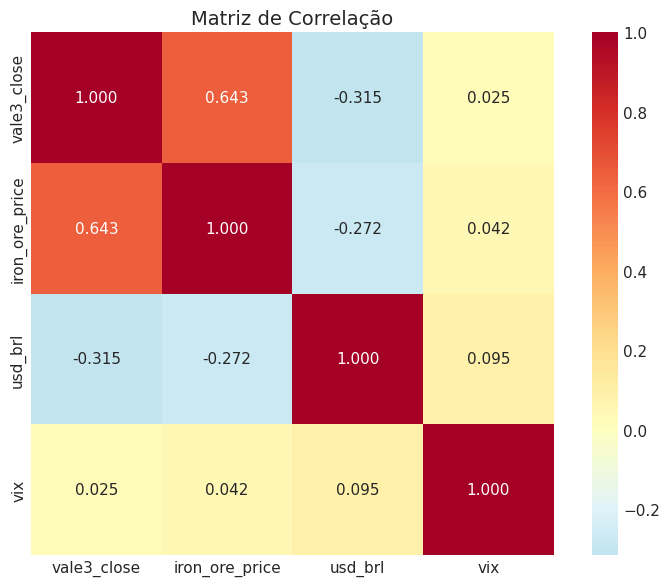

In [15]:
# Correlação entre todas as variáveis
cols = ['vale3_close', 'iron_ore_price', 'usd_brl', 'vix']
available_cols = [c for c in cols if c in df.columns and df[c].notna().sum() > 10]

corr_matrix = df[available_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.3f', square=True, ax=ax)
ax.set_title('Matriz de Correlação', fontsize=14)

plt.tight_layout()
plt.show()

## 10. Resumo e Conclusões

In [16]:
print("=" * 60)
print("RESUMO DA ANÁLISE EXPLORATÓRIA")
print("=" * 60)
print()
print(f"Período analisado: {df.index.min().date()} a {df.index.max().date()}")
print(f"Número de observações: {len(df)}")
print()
print("CORRELAÇÕES:")
print(f"  - Preços (VALE3 x Minério): {correlation_prices:.4f}")
print(f"  - Retornos (VALE3 x Minério): {correlation_returns:.4f}")
print(f"  - Correlação rolling média (20d): {rolling_corr.mean():.4f}")
print()
print("INTERPRETAÇÃO:")
if correlation_returns > 0.3:
    print("  -> Existe correlação positiva moderada a forte entre os retornos")
    print("  -> A hipótese de previsibilidade tem fundamento")
elif correlation_returns > 0.1:
    print("  -> Existe correlação positiva fraca entre os retornos")
    print("  -> A hipótese precisa de mais investigação")
else:
    print("  -> Correlação muito fraca ou inexistente")
    print("  -> A hipótese pode não ser válida")

print()
print("PRÓXIMOS PASSOS:")
print("  1. Implementar estratégia rule-based baseada nos thresholds")
print("  2. Backtesting com dados históricos")
print("  3. Validar critérios de NO-TRADE (VIX, variação cambial)")

RESUMO DA ANÁLISE EXPLORATÓRIA

Período analisado: 2021-01-18 a 2026-01-16
Número de observações: 1247

CORRELAÇÕES:
  - Preços (VALE3 x Minério): 0.6434
  - Retornos (VALE3 x Minério): 0.4355
  - Correlação rolling média (20d): 0.4110

INTERPRETAÇÃO:
  -> Existe correlação positiva moderada a forte entre os retornos
  -> A hipótese de previsibilidade tem fundamento

PRÓXIMOS PASSOS:
  1. Implementar estratégia rule-based baseada nos thresholds
  2. Backtesting com dados históricos
  3. Validar critérios de NO-TRADE (VIX, variação cambial)


In [2]:
from src.features import (                                                                                                       
      add_return_features,                                                                                                         
      add_volatility_features,                                                                                                     
      add_zscore_features,                                                                                                         
      validate_alignment,                                                                                                          
  )